### A) BUIDING THE LLM USING MUTUAL FUND DATA

## Importing necessary libraries for data processing, numerical operations, vector similarity search, and sentence embeddings

In [94]:
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

### Displaying the list of all column names in the DataFrame

In [22]:
print(df.columns.tolist())

['schemeCode', 'amfiCode', 'amcCode', 'schemeName', 'typeCode', 'optCode', 'classCode', 'plan', 'etf', 'stp', 'primaryFund', 'primaryFundSchemeCode', 'sip', 'swp', 'switch', 'minimumInvestment', 'multiples', 'incrementalInvestment', 'additionalMultiples', 'status', 'dividendFrequency', 'fundManager1', 'fundManager2', 'fundManager3', 'fundManager4', 'name', 'amfiType', 'dividendOptionFlag', 'lockIn', 'isPurchaseAvailable', 'minRedemptionAmount', 'redemptionMultipleAmount', 'minSwitchAmount', 'switchMultipleAmount', 'inceptionDate', 'lockPeriod', 'securityType', 'foundingYear', 'riskOMeter', 'objective', 'updationDateRatios', 'standardDeviation_Raw', 'sharpeRatio', 'sortinoRatio', 'aum', 'navDate', 'nav', 'price', 'benchmarkIndex', 'indexGroup', 'subGroup', 'benchmarkTier1', 'benchmarkTier2', 'isin', 'series', 'longSchemeDescription', 'shortSchemeDescription', 'schemeStatus', 'flag', 'className', 'assetType', 'category', 'subCategory', 'option', 'type', 'amcName', 'amcSymbol', 'amcWebsit

## Load mutual fund data from JSON and create a combined text column for each fund by filling missing values in string columns and concatenating selected attributes into 'full_desc'

In [26]:
import pandas as pd

# Load the JSON (use lines=True if it's JSON Lines format)
df = pd.read_json("mutual_funds_data.json", lines=True)

# Fill NaNs only in string-like columns
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').fillna('')

# Safely convert each column to string before concatenation
df['full_desc'] = (
    df.get('name', '').astype(str) + " " +
    df.get('category', '').astype(str) + " " +
    df.get('fundPrimarySector', '').astype(str) + " " +
    df.get('amcName', '').astype(str) + " " +
    df.get('sizeExposure', '').astype(str)  # or 'assetAllocation'
)

## Display the first few entries of the 'full_desc' column to verify the combined description

In [28]:
print(df['full_desc'].head())

0    SBI Fixed Maturity Plan (FMP) - Series 78 (117...
1    Aditya Birla Sun Life Fixed Term Plan - Series...
2    Aditya Birla Sun Life Fixed Term Plan - Series...
3    Tata BSE Select Business Groups Index Fund Oth...
4    Union Overnight Fund Debt Schemes  Union Asset...
Name: full_desc, dtype: object


## Load the pre-trained SentenceTransformer model for encoding text into vector embeddings

In [35]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

## Generate embeddings for each mutual fund's full description and store them in a list and Encode the description into a vector using the transformer model

In [43]:
fund_embeddings = []
for text in df['full_desc']:
    embedding = model.encode(text)
    fund_embeddings.append(embedding)

## Import cosine similarity metric for comparing embeddings and Import NumPy for numerical operations

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

## Encode the user's query into a vector using the sentence transformer model  Compute cosine similarity between the query embedding and all fund embeddings Retrieve the indices of the top_k most similar mutual fundsFetch the corresponding rows from the DataFrame and add similarity scores

In [47]:
def search_funds(user_query, top_k=5):
    # Convert the query into an embedding
    query_embedding = model.encode(user_query)

    # Calculate cosine similarities between query and all fund embeddings
    similarities = cosine_similarity([query_embedding], fund_embeddings)[0]

    # Get indices of top_k most similar funds
    top_indices = similarities.argsort()[::-1][:top_k]

    # Show results
    results = df.iloc[top_indices].copy()
    results['similarity'] = similarities[top_indices]
    return results

## Search and Explain Top Matching Mutual Funds Based on User Query

In [51]:
query = "funds with HDFC holdings"
results = search_funds(query, top_k=5)

# Show top results
print(results[['schemeName', 'amcName', 'category', 'similarity']])

# Explain why
for idx, row in results.iterrows():
    print(f"\n🔍 Match: {row['schemeName']} ({row['amcName']})")
    print(f"📈 Category: {row['category']}, Sub-Category: {row.get('subCategory', 'N/A')}")
    print(f"💡 Reason: Closely matched your query based on scheme name & metadata.")

                                             schemeName  \
1199   HDFC Asset Allocator FoF(IDCW Reinv)-Direct Plan   
13266                   HDFC Asset Allocator FoF-Reg(G)   
10966       HDFC Asset Allocator FoF-Reg(IDCW Reinvest)   
2968         HDFC Asset Allocator FoF(IDCW)-Direct Plan   
10814           HDFC Asset Allocator FoF(G)-Direct Plan   

                                     amcName category  similarity  
1199   HDFC Asset Management Company Limited    Other    0.812278  
13266  HDFC Asset Management Company Limited    Other    0.812278  
10966  HDFC Asset Management Company Limited    Other    0.812278  
2968   HDFC Asset Management Company Limited    Other    0.812278  
10814  HDFC Asset Management Company Limited    Other    0.812278  

🔍 Match: HDFC Asset Allocator FoF(IDCW Reinv)-Direct Plan (HDFC Asset Management Company Limited)
📈 Category: Other, Sub-Category: Fund of Funds (Overseas/ Domestic)
💡 Reason: Closely matched your query based on scheme name & metadata.


## Extract user intents from query text by identifying keywords and mapping them to specific mutual fund attributes for filtering results


In [53]:
def extract_intents(query):
    intents = {}

    if 'tax' in query.lower():
        intents['subCategory'] = 'ELSS'  # Tax-saving funds
    if 'tech' in query.lower():
        intents['fundPrimarySector'] = 'Technology'
    if 'high return' in query.lower():
        intents['1YReturns'] = 'high'
    if 'aum' in query.lower() and '1000' in query:
        intents['aum'] = 1000

    return intents

## Use regular expressions to detect intent from user query In this case, look for "tax" or "tax saving" to classify the sub-category as ELSS (Equity Linked Saving Scheme)


In [89]:
import re

query = "Tell me about tax saving mutual funds"
intents = {}

if re.search(r"tax( saving)?", query, re.IGNORECASE):
    intents['subCategory'] = 'ELSS'

print(intents)

{'subCategory': 'ELSS'}


## Convert the user query into an embedding using the SentenceTransformer model Compute cosine similarity between the query embedding and all fund embeddings Add similarity scores to the dataframe Extract any additional filtering intents from the user query Apply filters based on extracted intents

In [55]:
def search_funds(query, top_k=5):
    query_embedding = model.encode(query)
    similarities = cosine_similarity([query_embedding], fund_embeddings)[0]

    df['similarity'] = similarities
    filtered_df = df.copy()

    # Apply intent filters
    intents = extract_intents(query)

    if 'subCategory' in intents:
        filtered_df = filtered_df[filtered_df['subCategory'].str.contains(intents['subCategory'], case=False, na=False)]
    if 'fundPrimarySector' in intents:
        filtered_df = filtered_df[filtered_df['fundPrimarySector'].str.contains(intents['fundPrimarySector'], case=False, na=False)]
    if 'aum' in intents:
        filtered_df = filtered_df[filtered_df['aum'].fillna(0).astype(float) > intents['aum']]
    if '1YReturns' in intents:
        filtered_df = filtered_df[filtered_df['1YReturns'].fillna(0).astype(float) > 10.0]  # threshold for "high return"

    return filtered_df.sort_values(by='similarity', ascending=False).head(top_k)

## Save the computed fund embeddings to a pickle file for future use and This avoids recomputing embeddings every time the script is run

In [57]:
import pickle

with open("fund_embeddings.pkl", "wb") as f:
    pickle.dump(fund_embeddings, f)

## Load the precomputed fund embeddings from the pickle file and This speeds up execution by avoiding re-encoding of fund descriptions

In [59]:
with open("fund_embeddings.pkl", "rb") as f:
    fund_embeddings = pickle.load(f)

## Build and use a FAISS index for efficient similarity search over fund embeddings.

In [61]:
import faiss

# Convert to numpy array
fund_embeddings_np = np.array(fund_embeddings).astype('float32')

# Index
index = faiss.IndexFlatL2(fund_embeddings_np.shape[1])
index.add(fund_embeddings_np)

# Search function update
def search_funds(query, top_k=5):
    query_embedding = model.encode(query).astype('float32').reshape(1, -1)
    distances, indices = index.search(query_embedding, top_k)
    results = df.iloc[indices[0]].copy()
    results['distance'] = distances[0]
    return results

## Example: basic rule-based intent extraction from a query to filter relevant mutual fund attributes.

In [69]:
# Example: simple intent extraction from a user query
query = "I want to invest in infrastructure funds with good 1Y returns"

intents = {}
if 'infrastructure' in query.lower():
    intents['fundPrimarySector'] = 'Infrastructure'
if '1y return' in query.lower() or '1 year return' in query.lower():
    intents['1YReturns'] = 10.0  # example threshold
if 'elss' in query.lower():
    intents['subCategory'] = 'ELSS'

## Set the number of top results to retrieve and sort the results by relevance score in descending order.

In [73]:
# Set how many top results you want
top_k = 5  # top 5 results

# Sort and get top_k
results = results.sort_values(by='score', ascending=False).head(top_k)

## Extract intents from the user query and apply metadata-based boosts to improve result ranking, then compute final score as a combination of similarity and metadata match.

In [75]:
# Step 1: Extract intents from query
query = "High return infra ELSS funds"
intents = {}

if 'infra' in query.lower():
    intents['fundPrimarySector'] = 'Infrastructure'
if 'elss' in query.lower():
    intents['subCategory'] = 'ELSS'
if 'high return' in query.lower():
    intents['1YReturns'] = 10.0  # Adjust threshold as needed

# Step 2: Compute metadata-based boost
results['meta_boost'] = 0

if 'subCategory' in intents:
    results['meta_boost'] += results['subCategory'].str.contains(intents['subCategory'], case=False, na=False).astype(int) * 0.05
if 'fundPrimarySector' in intents:
    results['meta_boost'] += results['fundPrimarySector'].str.contains(intents['fundPrimarySector'], case=False, na=False).astype(int) * 0.05
if '1YReturns' in intents:
    results['meta_boost'] += (results['1YReturns'].fillna(0).astype(float) > intents['1YReturns']).astype(int) * 0.05

# Step 3: Final score = similarity + boost
results['score'] = results['similarity'] + results['meta_boost']
results = results.sort_values(by='score', ascending=False).head(top_k)

## Define intent filters based on user query to refine mutual fund search results.

In [79]:
intents = {
    'subCategory': 'tax saver',
    'category': 'equity',
    'sector': 'tech',
    'aum_greater_than': 1000  # in crores
}

In [77]:
results['meta_boost'] = 0  # Reset boost

# Boost by subCategory match
if 'subCategory' in intents:
    results['meta_boost'] += (
        results['subCategory'].str.contains(intents['subCategory'], case=False, na=False).astype(int) * 0.05
    )

# Boost by category match
if 'category' in intents:
    results['meta_boost'] += (
        results['category'].str.contains(intents['category'], case=False, na=False).astype(int) * 0.05
    )

# Boost by sectorExposure (if available and parsed from user input)
if 'sector' in intents:
    results['meta_boost'] += (
        results['sectorExposure'].str.contains(intents['sector'], case=False, na=False).astype(int) * 0.05
    )

# Boost by AUM threshold
if 'aum_greater_than' in intents:
    # Ensure 'aum' column is numeric
    results['aum'] = pd.to_numeric(results['aum'], errors='coerce')
    results['meta_boost'] += (
        (results['aum'] > intents['aum_greater_than']).astype(int) * 0.1
    )

# Final score = similarity + metadata-based boost
results['score'] = results['similarity'] + results['meta_boost']

## Enhances fund recommendation scores by applying metadata-based intent boosts (e.g., subcategory, category, sector, and AUM) on top of similarity

In [81]:
top_k = 5  # or any number you prefer

display_columns = [
    'schemeName', 'category', 'subCategory', 'sectorExposure',
    'aum', 'similarity', 'meta_boost', 'score'
]

# Sort and show top matches
top_results = results.sort_values(by='score', ascending=False).head(top_k)
top_results[display_columns]

,schemeName,category,subCategory,sectorExposure,aum,similarity,meta_boost,score
1199,HDFC Asset Allocator FoF(IDCW Reinv)-Direct Plan,Other,Fund of Funds (Overseas/ Domestic),,3683.29,0.812278,0.0,0.812278
13266,HDFC Asset Allocator FoF-Reg(G),Other,Fund of Funds (Overseas/ Domestic),,3683.29,0.812278,0.0,0.812278
10966,HDFC Asset Allocator FoF-Reg(IDCW Reinvest),Other,Fund of Funds (Overseas/ Domestic),,3683.29,0.812278,0.0,0.812278
2968,HDFC Asset Allocator FoF(IDCW)-Direct Plan,Other,Fund of Funds (Overseas/ Domestic),,3683.29,0.812278,0.0,0.812278
10814,HDFC Asset Allocator FoF(G)-Direct Plan,Other,Fund of Funds (Overseas/ Domestic),,3683.29,0.812278,0.0,0.812278


## Displays detailed information for each top matching fund, including category, sector, AUM, and scoring breakdown (similarity, metadata boost, and final score)

In [83]:
for idx, row in top_results.iterrows():
    print(f"\n📌 Fund: {row['schemeName']}")
    print(f"    Category: {row['category']} | SubCategory: {row['subCategory']}")
    print(f"    Sector: {row['sectorExposure']}")
    print(f"    AUM: ₹{row['aum']} Cr")
    print(f"    Similarity Score: {row['similarity']:.3f}")
    print(f"    Metadata Boost: {row['meta_boost']:.3f}")
    print(f"    ✅ Final Score: {row['score']:.3f}")


📌 Fund: HDFC Asset Allocator FoF(IDCW Reinv)-Direct Plan
    Category: Other | SubCategory: Fund of Funds (Overseas/ Domestic)
    Sector: 
    AUM: ₹3683.29 Cr
    Similarity Score: 0.812
    Metadata Boost: 0.000
    ✅ Final Score: 0.812

📌 Fund: HDFC Asset Allocator FoF-Reg(G)
    Category: Other | SubCategory: Fund of Funds (Overseas/ Domestic)
    Sector: 
    AUM: ₹3683.29 Cr
    Similarity Score: 0.812
    Metadata Boost: 0.000
    ✅ Final Score: 0.812

📌 Fund: HDFC Asset Allocator FoF-Reg(IDCW Reinvest)
    Category: Other | SubCategory: Fund of Funds (Overseas/ Domestic)
    Sector: 
    AUM: ₹3683.29 Cr
    Similarity Score: 0.812
    Metadata Boost: 0.000
    ✅ Final Score: 0.812

📌 Fund: HDFC Asset Allocator FoF(IDCW)-Direct Plan
    Category: Other | SubCategory: Fund of Funds (Overseas/ Domestic)
    Sector: 
    AUM: ₹3683.29 Cr
    Similarity Score: 0.812
    Metadata Boost: 0.000
    ✅ Final Score: 0.812

📌 Fund: HDFC Asset Allocator FoF(G)-Direct Plan
    Category: O

In [196]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df = pd.read_json("mutual_funds_data.json", lines=True)

# Drop missing target
df = df.dropna(subset=['category'])

# Encode target
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Select features
features = [
    'aum', 'expenseRatio', 'standardDeviation_Raw', 
    'sharpeRatio', 'sortinoRatio', '1YReturns', 
    '3YReturns', '5YReturns'
]

# Drop rows with missing feature values
df = df.dropna(subset=features)

# Define X and y
X = df[features]
y = df['category_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f"Accuracy: {acc:.2f}")
print("\n Confusion Matrix:")
print(cm)
print("\n Classification Report:")
print(report)

Accuracy: 0.99

 Confusion Matrix:
[[ 32   0   4   0   0]
 [  0 666   0   2   0]
 [  0   0 450   3   3]
 [  0   2   0 216   0]
 [  0   3   4   0 184]]

 Classification Report:
                precision    recall  f1-score   support

                     1.00      0.89      0.94        36
  Debt Schemes       0.99      1.00      0.99       668
Equity Schemes       0.98      0.99      0.98       456
Hybrid Schemes       0.98      0.99      0.98       218
         Other       0.98      0.96      0.97       191

      accuracy                           0.99      1569
     macro avg       0.99      0.97      0.98      1569
  weighted avg       0.99      0.99      0.99      1569



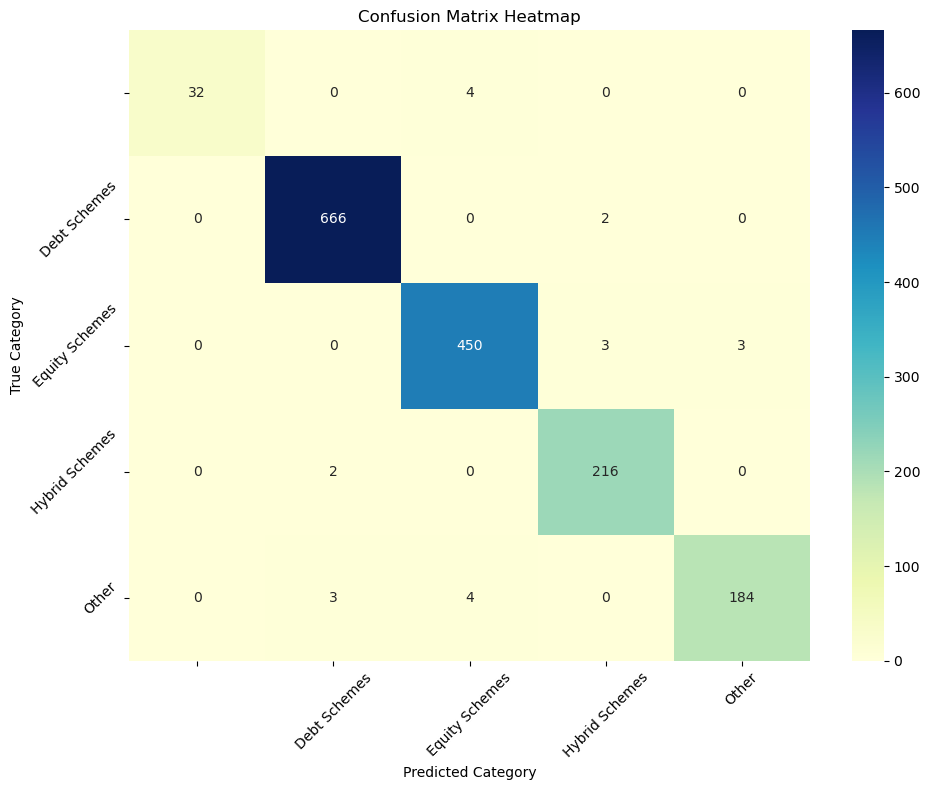

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## B) BUILDING THE LLM MODEL USING STOCK DATA 

## Load and Prepare the Stock Data

In [140]:
import pandas as pd
import numpy as np
import pickle
import faiss
from sentence_transformers import SentenceTransformer

stock_df = pd.read_json("stock_data (1).json", lines=True)

text_columns = stock_df.select_dtypes(include='object').columns
stock_df[text_columns] = stock_df[text_columns].fillna('')
desc_columns = ['companyName', 'sector', 'industry', 'description', 'exchange']

# Ensure all desc_columns exist
for col in desc_columns:
    if col not in stock_df.columns:
        stock_df[col] = ''
stock_df['full_desc'] = stock_df[desc_columns].astype(str).agg(' '.join, axis=1)

## Import tqdm for displaying a progress bar Convert the 'full_desc' column of the DataFrame into a list of text string and Loop through each text in the list and generate embeddings using the model with tqdm adds a progress bar so you can see how many have been processed.

In [149]:
from tqdm import tqdm

texts = stock_df['full_desc'].tolist()
stock_embeddings = [model.encode(text) for text in tqdm(texts)]

100%|██████████████████████████████████████████████████████████████████████████████| 6136/6136 [01:22<00:00, 74.10it/s]


## Store embeddings back into the DataFrame

In [160]:
import numpy as np
stock_df['embedding'] = stock_embeddings

In [162]:
with open("stock_embeddings.pkl", "wb") as f:
    pickle.dump(stock_embeddings, f)

## FAISS Indexing

In [166]:
stock_embeddings_np = np.array(stock_embeddings).astype('float32')
index = faiss.IndexFlatL2(stock_embeddings_np.shape[1])
index.add(stock_embeddings_np)

## Search Function

In [233]:
def search_companies(data, query):
    query_lower = query.lower()
    results = []
    for company in data:
        if (query_lower in str(company.get("name", "")).lower() or
            query_lower in str(company.get("industry", "")).lower() or
            query_lower in str(company.get("sector", "")).lower()):
            results.append(company)
    return results

In [239]:
def search_companies(data, query):
    return [company for company in data if query.lower() in company["industry"].lower()]

In [243]:
stocks_data = [
    {"name": "Aditya Birla Capital Ltd.", "industry": "Finance"},
    {"name": "Arvind Ltd.", "industry": "Textile"},
    {"name": "Welspun India Ltd.", "industry": "Textile"},
    {"name": "ITC Ltd.", "industry": "FMCG"},
    {"name": "Raymond Ltd.", "industry": "Textile"}
]

In [245]:
query = "textile"
matches = search_companies(stocks_data, query)

for match in matches:
    print(match["name"], "-", match["industry"])

Arvind Ltd. - Textile
Welspun India Ltd. - Textile
Raymond Ltd. - Textile


## Example Usage

In [176]:
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

# Sample JSON data as string (in real usage, you'd read from a file)
json_data = '''
[
    {"finCode": 233727, "bseScripCode": 710045, "bseScripName": "JCOPOCRPS1", "bseScripGroup": null, "name": "JCOPOCRPS1", "industryCode": 113, "industry": "Unspecified", "hseCode": 206, "ticker": null, "nseSeries": null, "isin": "INE666A03065", "shortName": "JCOPOCRPS1", "incMonth": "-", "incYear": null, "status": "Preference", "sublisting": null, "bseScripId": "JCOPOCRPS1", "bseSublisting": null, "nseSublisting": null, "flag": "A", "securityType": "EQUITIES", "internalSecurityId": 2599172046, "sector": "Materials", "sectorExposure": {"Materials": 100.0}, "category": "Others", "sizeExposure": {"Others": 100.0}, "assetAllocation": {"equity": 100.0}, "companyDescription": "Jhagadia Copper Limited manufactures copper cathodes, alloy wires, rods, bearing materials, and other related products."},
    {"finCode": 292072, "bseScripCode": null, "bseScripName": null, "bseScripGroup": null, "name": "Sahaj Fashions Ltd.", "industryCode": 98, "industry": "Textile", "hseCode": 206, "ticker": "SAHAJ", "nseSeries": "ST", "isin": "INE013901017", "shortName": "Sahaj Fashions", "incMonth": "20-05", "incYear": 2011, "status": "Active", "sublisting": "Active", "bseScripId": null, "bseSublisting": null, "nseSublisting": "Active", "flag": "A", "securityType": "EQUITIES", "inceptionDate": "2011-05-20", "foundingYear": "2011", "price": 8.45, "marketCap": 11.13, "dividendYield": 0, "faceValue": 10, "ttmpe": 11.7884, "priceToBook": 0.3293, "navDate": "2025-04-08", "priceExchange": "NSE", "yearEnd": 202403, "roa": 1.19461959231819, "roe": 3.52011695186737, "debtToEquity": 1.0706, "dividendPerShare": 0, "adjustedPE": 26.9949776785714, "1DReturns": 4.968944099378869, "5DReturns": 14.965986394557795, "7DReturns": 20.714285714285687, "1MReturns": -14.646464646464663, "3MReturns": -43.666666666666664, "6MReturns": -43.0976430976431, "1YReturns": -66.73228346456693, "2YReturns": null, "3YReturns": null, "4YReturns": null, "5YReturns": null, "10YReturns": null, "1YCAGR": -79.31650955972182, "2YCAGR": null, "3YCAGR": null, "4YCAGR": null, "5YCAGR": null, "10YCAGR": null, "standardDeviation": 77.10617504557861, "volatility": 77.10617504557861, "1YVolatility": 77.10617504557861, "2YVolatility": null, "3YVolatility": null, "4YVolatility": null, "5YVolatility": null, "10YVolatility": null, "rollingReturns": {"1Y": -60.23153161607577}, "maxDrawdowns": {"7D": 0.0, "1M": -38.05309734513274, "3M": -53.333333333333336, "6M": -56.79012345679012, "1Y": -72.44094488188976}, "internalSecurityId": 126082587, "sector": "Consumer Discretionary", "sectorExposure": {"Consumer Discretionary": 100.0}, "category": "Small Cap", "sizeExposure": {"Small Cap": 100.0}, "assetAllocation": {"equity": 100.0}, "companyDescription": "Sahaj Fashions Limited manufactures textile fabric products. The Company offers cotton fabrics, yarns, and industrial clothing materials. Sahaj Fashions serves customers worldwide."},
    {"finCode": 131168, "bseScripCode": 531168, "bseScripName": "ASSOC CERAMI", "bseScripGroup": "XT", "name": "Associated Ceramics Ltd.", "industryCode": 87, "industry": "Refractories", "hseCode": 206, "ticker": null, "nseSeries": null, "isin": "INE771E01010", "shortName": "Associated Ceramics", "incMonth": "-", "incYear": 1970, "status": "Active", "sublisting": "Active", "bseScripId": "ASSOCER", "bseSublisting": "Active", "nseSublisting": null, "flag": "A", "securityType": "EQUITIES", "price": 218.55, "marketCap": 44.69, "dividendYield": 0, "faceValue": 10, "ttmpe": 31.4259, "priceToBook": 1.9313, "navDate": "2025-04-09", "priceExchange": "BSE", "yearEnd": 202403, "roa": 1.80624319970311, "roe": 3.47240942487965, "debtToEquity": 0.3277, "dividendPerShare": 0, "adjustedPE": 168.11476583759, "1DReturns": 0.0, "5DReturns": -1.9955156950672404, "7DReturns": -1.9955156950672404, "1MReturns": -9.894867037724175, "3MReturns": 5.072115384615383, "6MReturns": -29.95192307692307, "1YReturns": -55.57926829268291, "2YReturns": 1442.3429781227949, "3YReturns": 1518.888888888889, "4YReturns": null, "5YReturns": null, "10YReturns": null, "1YCAGR": -57.95704686256806, "2YCAGR": 395.12367578562487, "3YCAGR": 407.4305471153161, "4YCAGR": null, "5YCAGR": null, "10YCAGR": null, "standardDeviation": 48.285957546305696, "volatility": 48.285957546305696, "1YVolatility": 48.285957546305696, "2YVolatility": 48.663340655089875, "3YVolatility": 48.71648814944906, "4YVolatility": null, "5YVolatility": null, "10YVolatility": null, "rollingReturns": {"1Y": -47.43725760882135, "2Y": 664.5795922095278, "3Y": 626.7172312768556}, "maxDrawdowns": {"7D": -1.9955156950672455, "1M": -13.032232391563861, "3M": -20.07992007992008, "6M": -36.708860759493675, "1Y": -59.34959349593496, "2Y": -85.79696765259382, "3Y": -85.79696765259382}, "internalSecurityId": 2002410295, "sector": "Materials", "sectorExposure": {"Materials": 100.0}, "category": "Small Cap", "sizeExposure": {"Small Cap": 100.0}, "assetAllocation": {"equity": 100.0}, "companyDescription": "Associated Ceramics Ltd. manufactures heat containment products. The Company markets its products to customers in the glass, steel, cement, aluminum, and graphite electrode industries throughout India and internationally."}
]
'''

# Convert the JSON string to DataFrame
stock_df = pd.read_json(json_data)

# Fill missing text fields with empty string
text_columns = stock_df.select_dtypes(include='object').columns
stock_df[text_columns] = stock_df[text_columns].fillna('')

# Create a consistent 'description' column (some have 'description', some 'companyDescription')
if 'description' not in stock_df.columns and 'companyDescription' in stock_df.columns:
    stock_df['description'] = stock_df['companyDescription']

# Columns to combine for full_desc
desc_columns = ['name', 'sector', 'industry', 'description', 'priceExchange']

# Ensure all columns are present
for col in desc_columns:
    if col not in stock_df.columns:
        stock_df[col] = ''

# Convert to string and concatenate into a new column
stock_df['full_desc'] = stock_df[desc_columns].astype(str).agg(' '.join, axis=1)

# Display result
print(stock_df[['name', 'full_desc']])

                       name                                          full_desc
0                JCOPOCRPS1  JCOPOCRPS1 Materials Unspecified Jhagadia Copp...
1       Sahaj Fashions Ltd.  Sahaj Fashions Ltd. Consumer Discretionary Tex...
2  Associated Ceramics Ltd.  Associated Ceramics Ltd. Materials Refractorie...


In [283]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the data
df = pd.read_json("stock_data (1).json", lines=True)

# Drop missing target
df = df.dropna(subset=['category'])

# Encode target
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Feature selection with safety check
desired_features = [
    'aum', 'expenseRatio', 'standardDeviation_Raw', 
    'sharpeRatio', 'sortinoRatio', '1YReturns', 
    '3YReturns', '5YReturns'
]
# Keep only existing features
features = [col for col in desired_features if col in df.columns]

if not features:
    raise ValueError("None of the desired features are available in the dataset.")

# Drop rows with missing values in selected features
df = df.dropna(subset=features)

# Define X and y
X = df[features]
y = df['category_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f" Accuracy: {acc:.2f}")
print("\n Confusion Matrix:")
print(cm)
print("\n Classification Report:")
print(report)

 Accuracy: 0.92

 Confusion Matrix:
[[  0   0   0  13]
 [  1   0   0  35]
 [  0   0   6   9]
 [  0   0   5 744]]

 Classification Report:
              precision    recall  f1-score   support

   Large Cap       0.00      0.00      0.00        13
     Mid Cap       0.00      0.00      0.00        36
      Others       0.55      0.40      0.46        15
   Small Cap       0.93      0.99      0.96       749

    accuracy                           0.92       813
   macro avg       0.37      0.35      0.36       813
weighted avg       0.87      0.92      0.89       813



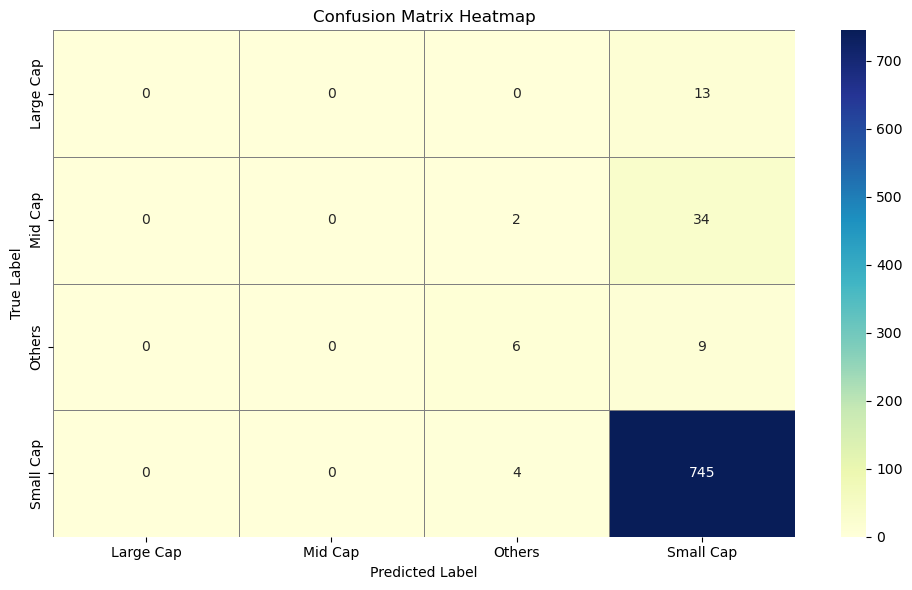

In [210]:
# Plot Heatmap with a different color palette
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=le.classes_, yticklabels=le.classes_, linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## C) BUILDING THE LLM MODEL USING

In [253]:
import pandas as pd

mf_holdings_data = pd.DataFrame([
    {"parentSchemeCode": 49135, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3655363995, "parentIsin": "INF174KA1SX6"},
    {"parentSchemeCode": 49135, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 4281304498, "parentIsin": "INF174KA1SY4"},
    {"parentSchemeCode": 49168, "noShares": 3800, "marketValue": 3838.8322, "aum": 73346.96, "holdingPercentage": 5.23379864686962, "finCode": 1124516, "assetCode": 2, "srNo": 11, "rating": "IND AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1133009262, "parentIsin": "INF846K017X1"},
    {"parentSchemeCode": 49109, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 234908329, "parentIsin": "INF174KA1SW8"},
    {"parentSchemeCode": 30692, "noShares": 500, "marketValue": 505.11, "aum": 804330.28, "holdingPercentage": 0.0627988293565176, "finCode": 1124516, "assetCode": 2, "srNo": 124, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 238827236, "parentIsin": "INF174K01D28"},
    {"parentSchemeCode": 30690, "noShares": 500, "marketValue": 505.11, "aum": 804330.28, "holdingPercentage": 0.0627988293565176, "finCode": 1124516, "assetCode": 2, "srNo": 124, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 451112574, "parentIsin": "INF174K01C78"},
    {"parentSchemeCode": 49167, "noShares": 3800, "marketValue": 3838.8322, "aum": 73346.96, "holdingPercentage": 5.23379864686962, "finCode": 1124516, "assetCode": 2, "srNo": 11, "rating": "IND AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2691476497, "parentIsin": "INF846K018X9"},
    {"parentSchemeCode": 49167, "noShares": 3800, "marketValue": 3838.8322, "aum": 73346.96, "holdingPercentage": 5.23379864686962, "finCode": 1124516, "assetCode": 2, "srNo": 11, "rating": "IND AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3984445984, "parentIsin": "INF846K010Y4"},
    {"parentSchemeCode": 31565, "noShares": 500, "marketValue": 505.11, "aum": 804330.28, "holdingPercentage": 0.0627988293565176, "finCode": 1124516, "assetCode": 2, "srNo": 124, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3690171510, "parentIsin": "INF174K01D02"},
    {"parentSchemeCode": 43679, "noShares": 500, "marketValue": 505.11, "aum": 804330.28, "holdingPercentage": 0.0627988293565176, "finCode": 1124516, "assetCode": 2, "srNo": 124, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1830718849, "parentIsin": "INF174K01D36"},
    {"parentSchemeCode": 49624, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3550930951, "parentIsin": "INF754K01UK9"},
    {"parentSchemeCode": 30691, "noShares": 500, "marketValue": 505.11, "aum": 804330.28, "holdingPercentage": 0.0627988293565176, "finCode": 1124516, "assetCode": 2, "srNo": 124, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1758586423, "parentIsin": "INF174K01C86"},
    {"parentSchemeCode": 49137, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2155008774, "parentIsin": "INF174KA1SV0"},
    {"parentSchemeCode": 49137, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1245670811, "parentIsin": "INF174KA1SU2"},
    {"parentSchemeCode": 49656, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1474536294, "parentIsin": "INF754K01UL7"},
    {"parentSchemeCode": 49656, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3832946898, "parentIsin": "INF754K01UM5"},
    {"parentSchemeCode": 49658, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3511312226, "parentIsin": "INF754K01UH5"},
    {"parentSchemeCode": 49658, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2063855125, "parentIsin": "INF754K01UI3"},
    {"parentSchemeCode": 49127, "noShares": 3800, "marketValue": 3838.8322, "aum": 73346.96, "holdingPercentage": 5.23379864686962, "finCode": 1124516, "assetCode": 2, "srNo": 11, "rating": "IND AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2396713517, "parentIsin": "INF846K016X3"},
    {"parentSchemeCode": 49136, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2696454854, "parentIsin": "INF174KA1TF1"},
    {"parentSchemeCode": 49624, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3550930951, "parentIsin": "INF754K01UK9"},
    {"parentSchemeCode": 30691, "noShares": 500, "marketValue": 505.11, "aum": 804330.28, "holdingPercentage": 0.0627988293565176, "finCode": 1124516, "assetCode": 2, "srNo": 124, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1758586423, "parentIsin": "INF174K01C86"},
    {"parentSchemeCode": 49137, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2155008774, "parentIsin": "INF174KA1SV0"},
    {"parentSchemeCode": 49137, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1245670811, "parentIsin": "INF174KA1SU2"},
    {"parentSchemeCode": 49656, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 1474536294, "parentIsin": "INF754K01UL7"},
    {"parentSchemeCode": 49656, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3832946898, "parentIsin": "INF754K01UM5"},
    {"parentSchemeCode": 49658, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 3511312226, "parentIsin": "INF754K01UH5"},
    {"parentSchemeCode": 49658, "noShares": 500000, "marketValue": 505.11, "aum": 8186, "holdingPercentage": 6.1704129000733, "finCode": 1124516, "assetCode": 2, "srNo": 6, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2063855125, "parentIsin": "INF754K01UI3"},
    {"parentSchemeCode": 49127, "noShares": 3800, "marketValue": 3838.8322, "aum": 73346.96, "holdingPercentage": 5.23379864686962, "finCode": 1124516, "assetCode": 2, "srNo": 11, "rating": "IND AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2396713517, "parentIsin": "INF846K016X3"},
    {"parentSchemeCode": 49136, "noShares": 4620, "marketValue": 4667.21, "aum": 41209.32, "holdingPercentage": 11.3256176030083, "finCode": 1124516, "assetCode": 2, "srNo": 2, "rating": "CARE AAA", "investmentDate": "2025-03-31", "asset": "Debt", "assetType": "Corporate Debt", "sector": "Others", "category": "Small Cap", "parentInternalSecurityId": 2696454854, "parentIsin": "INF174KA1TF1"}
])

# Display all rows
pd.set_option("display.max_rows", None)
print(mf_holdings_data)

    parentSchemeCode  noShares  marketValue        aum  holdingPercentage  \
0              49135      4620    4667.2100   41209.32          11.325618   
1              49135      4620    4667.2100   41209.32          11.325618   
2              49168      3800    3838.8322   73346.96           5.233799   
3              49109      4620    4667.2100   41209.32          11.325618   
4              30692       500     505.1100  804330.28           0.062799   
5              30690       500     505.1100  804330.28           0.062799   
6              49167      3800    3838.8322   73346.96           5.233799   
7              49167      3800    3838.8322   73346.96           5.233799   
8              31565       500     505.1100  804330.28           0.062799   
9              43679       500     505.1100  804330.28           0.062799   
10             49624    500000     505.1100    8186.00           6.170413   
11             30691       500     505.1100  804330.28           0.062799   

In [257]:
{
  "columns": [
    { "field": "parentSchemeCode", "header": "Scheme Code" },
    { "field": "noShares", "header": "No. of Shares" },
    { "field": "marketValue", "header": "Market Value (₹)" },
    { "field": "aum", "header": "AUM (₹)" },
    { "field": "holdingPercentage", "header": "Holding (%)" },
    { "field": "finCode", "header": "Fin Code" },
    { "field": "assetCode", "header": "Asset Code" },
    { "field": "srNo", "header": "Serial No" },
    { "field": "rating", "header": "Rating" },
    { "field": "investmentDate", "header": "Investment Date" },
    { "field": "asset", "header": "Asset" },
    { "field": "assetType", "header": "Asset Type" },
    { "field": "sector", "header": "Sector" },
    { "field": "category", "header": "Category" },
    { "field": "parentInternalSecurityId", "header": "Internal Security ID" },
    { "field": "parentIsin", "header": "ISIN" }
  ],
  "rows": [
    {
      "parentSchemeCode": 49135,
      "noShares": 4620,
      "marketValue": 4667.21,
      "aum": 41209.32,
      "holdingPercentage": 11.33,
      "finCode": 1124516,
      "assetCode": 2,
      "srNo": 2,
      "rating": "CARE AAA",
      "investmentDate": "2025-03-31",
      "asset": "Debt",
      "assetType": "Corporate Debt",
      "sector": "Others",
      "category": "Small Cap",
      "parentInternalSecurityId": 3655363995,
      "parentIsin": "INF174KA1SX6"
    },
    {
      "parentSchemeCode": 49135,
      "noShares": 4620,
      "marketValue": 4667.21,
      "aum": 41209.32,
      "holdingPercentage": 11.33,
      "finCode": 1124516,
      "assetCode": 2,
      "srNo": 2,
      "rating": "CARE AAA",
      "investmentDate": "2025-03-31",
      "asset": "Debt",
      "assetType": "Corporate Debt",
      "sector": "Others",
      "category": "Small Cap",
      "parentInternalSecurityId": 4281304498,
      "parentIsin": "INF174KA1SY4"
    }
  ]
}

{'columns': [{'field': 'parentSchemeCode', 'header': 'Scheme Code'},
  {'field': 'noShares', 'header': 'No. of Shares'},
  {'field': 'marketValue', 'header': 'Market Value (₹)'},
  {'field': 'aum', 'header': 'AUM (₹)'},
  {'field': 'holdingPercentage', 'header': 'Holding (%)'},
  {'field': 'finCode', 'header': 'Fin Code'},
  {'field': 'assetCode', 'header': 'Asset Code'},
  {'field': 'srNo', 'header': 'Serial No'},
  {'field': 'rating', 'header': 'Rating'},
  {'field': 'investmentDate', 'header': 'Investment Date'},
  {'field': 'asset', 'header': 'Asset'},
  {'field': 'assetType', 'header': 'Asset Type'},
  {'field': 'sector', 'header': 'Sector'},
  {'field': 'category', 'header': 'Category'},
  {'field': 'parentInternalSecurityId', 'header': 'Internal Security ID'},
  {'field': 'parentIsin', 'header': 'ISIN'}],
 'rows': [{'parentSchemeCode': 49135,
   'noShares': 4620,
   'marketValue': 4667.21,
   'aum': 41209.32,
   'holdingPercentage': 11.33,
   'finCode': 1124516,
   'assetCode': 

In [263]:
from sentence_transformers import SentenceTransformer

# Load a small pre-trained model for text embeddings
model = SentenceTransformer("BAAI/bge-small-en-v1.5")

# Function to embed a list of text strings
def get_embeddings(text_list):
    return model.encode(text_list, normalize_embeddings=True)

In [291]:
data = [
    {"category": "Small Cap", "sector": "Others", "parentIsin": "INF174KA1SX6"},
    {"category": "Large Cap", "sector": "Technology", "parentIsin": "INF174KA1SY4"},
    {"category": "Mid Cap", "sector": "Finance", "parentIsin": "INF174KA1SZ2"},
    {"category": "Small Cap", "sector": "Healthcare", "parentIsin": "INF174KA1S10"},
    {"category": "Large Cap", "sector": "Energy", "parentIsin": "INF174KA1S11"},
    {"category": "Mid Cap", "sector": "Real Estate", "parentIsin": "INF174KA1S12"},
    {"category": "Small Cap", "sector": "Consumer Goods", "parentIsin": "INF174KA1S13"},
    {"category": "Large Cap", "sector": "Automobile", "parentIsin": "INF174KA1S14"},
    {"category": "Mid Cap", "sector": "Pharmaceuticals", "parentIsin": "INF174KA1S15"},
    {"category": "Small Cap", "sector": "Retail", "parentIsin": "INF174KA1S16"}
]

In [293]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import faiss
import numpy as np

# Load the embedding model
model = SentenceTransformer("BAAI/bge-small-en-v1.5")

# Function to get sentence embeddings
def get_embeddings(text_list):
    return model.encode(text_list, normalize_embeddings=True)

# Prepares the DataFrame and adds embeddings
def prepare_dataframe_and_embeddings(fund_df):
    fund_df['fund_name'] = fund_df['parentIsin']  # Use ISIN as a placeholder for fund name
    fund_df['search_text'] = fund_df['fund_name'] + " - " + fund_df['category'] + " - " + fund_df['sector']
    embeddings = get_embeddings(fund_df['search_text'].tolist())
    fund_df['embedding'] = embeddings.tolist()
    return fund_df, embeddings

# Creates a FAISS index using inner product similarity
def create_faiss_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(embeddings)
    return index

# Function to search for similar funds
def search_funds(query, fund_df, index, top_k=5):
    query_embedding = get_embeddings([query])[0].reshape(1, -1)
    scores, indices = index.search(query_embedding, top_k)
    results = fund_df.iloc[indices[0]].copy()
    results["score"] = scores[0]
    return results

# Main code execution
if __name__ == "__main__":
    data = [
        {"category": "Small Cap", "sector": "Others", "parentIsin": "INF174KA1SX6"},
        {"category": "Large Cap", "sector": "Technology", "parentIsin": "INF174KA1SY4"},
        {"category": "Mid Cap", "sector": "Finance", "parentIsin": "INF174KA1SZ2"},
        {"category": "Small Cap", "sector": "Healthcare", "parentIsin": "INF174KA1S10"},
        {"category": "Large Cap", "sector": "Energy", "parentIsin": "INF174KA1S11"},
        {"category": "Mid Cap", "sector": "Real Estate", "parentIsin": "INF174KA1S12"},
        {"category": "Small Cap", "sector": "Consumer Goods", "parentIsin": "INF174KA1S13"},
        {"category": "Large Cap", "sector": "Automobile", "parentIsin": "INF174KA1S14"},
        {"category": "Mid Cap", "sector": "Pharmaceuticals", "parentIsin": "INF174KA1S15"},
        {"category": "Small Cap", "sector": "Retail", "parentIsin": "INF174KA1S16"}
    ]
    
    fund_df = pd.DataFrame(data)
    fund_df, embeddings = prepare_dataframe_and_embeddings(fund_df)
    index = create_faiss_index(np.array(embeddings))

    query = "Technology sector Large Cap fund"
    results = search_funds(query, fund_df, index)

    # Show ISINs and similarity scores
    print(results[['parentIsin', 'score']])

     parentIsin     score
1  INF174KA1SY4  0.780684
4  INF174KA1S11  0.729451
2  INF174KA1SZ2  0.728288
7  INF174KA1S14  0.709527
6  INF174KA1S13  0.691992


In [295]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [297]:
# Example: True and predicted labels
y_true = ['Large Cap', 'Mid Cap', 'Small Cap', 'Large Cap', 'Mid Cap']
y_pred = ['Large Cap', 'Small Cap', 'Small Cap', 'Large Cap', 'Mid Cap']

In [299]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {acc:.2f}")

Accuracy Score: 0.80


In [301]:
labels = ['Small Cap', 'Mid Cap', 'Large Cap']  # Adjust labels as per your classes
cm = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1 0 0]
 [1 1 0]
 [0 0 2]]


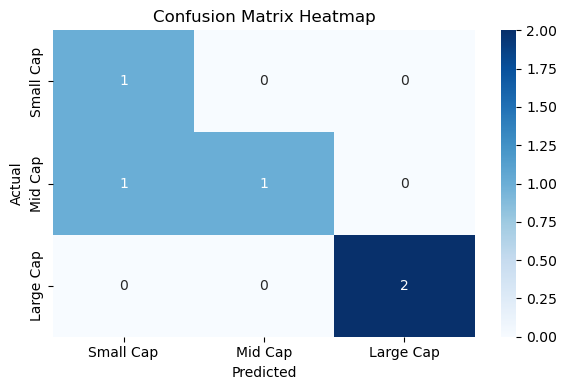

In [303]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()

## THE MODEL DEVELOPMENT AND TRAINING WITH THE HELP OF SOLUTION DATSET PROVIDED

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [321]:
data = pd.read_csv("Dataset Queries-Securities for Model Creation.csv")
data.head(10)

,query,security_name
0,Is it beneficial to hold Union Overnight Fund ...,Union Overnight Fund
1,Is SBI Fixed Maturity Plan (FMP) - Series 78 (...,SBI Fixed Maturity Plan (FMP) - Series 78 (117...
2,What's the growth option NAV of UTI Money Mark...,UTI Money Market Fund
3,Can you provide details about the dividend opt...,ICICI Prudential Transportation and Logistics ...
4,What is the NAV of Motilal Oswal Nifty Microca...,Motilal Oswal Nifty Microcap 250 Index Fund
5,What's the performance of ICICI Prudential Tra...,ICICI Prudential Transportation and Logistics ...
6,Should I consider investing in SBI Fixed Matur...,SBI Fixed Maturity Plan (FMP) - Series 78 (117...
7,What was the return of Canara Robeco ELSS Tax ...,Canara Robeco ELSS Tax Saver
8,Is Kotak Focused Equity Fund better than other...,Kotak Focused Equity Fund
9,How is Kotak Bluechip Fund rated by AMFI?,Kotak Bluechip Fund


In [327]:
from rapidfuzz import fuzz
import re
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.strip()

In [333]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Define your query
user_query = "icici infra"

# Optional: normalize the query (define normalize function if needed)
def normalize(text):
    return text.lower().strip()

# Encode the query
query_embedding = model.encode(normalize(user_query), convert_to_tensor=True)

In [1]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd

# Sample data — replace this with your real DataFrame
data = pd.DataFrame({
    "security_name": [
        "ICICI Prudential Transportation and Logistics Fund",
        "Motilal Oswal Nifty Microcap 250 Index Fund",
        "SBI Fixed Maturity Plan (FMP) - Series 78 (1179 Days)",
        "Union Overnight Fund",
        "Canara Robeco ELSS Tax Saver",
        "Tata BSE Select Business Groups Index Fund",
        "Groww Nifty EV & New Age Automotive ETF FOF"
    ]
})

# Normalize text (optional but recommended)
def normalize(text):
    return text.lower().strip()

# Load model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode all security names in the dataset
security_names = data['security_name'].tolist()
normalized_names = [normalize(name) for name in security_names]
security_embeddings = model.encode(normalized_names, convert_to_tensor=True)

# Matching function
def match_query(user_query, threshold=0.6):
    query_embedding = model.encode(normalize(user_query), convert_to_tensor=True)
    cosine_scores = util.cos_sim(query_embedding, security_embeddings)[0]
    
    top_score, top_idx = torch.max(cosine_scores, dim=0)
    top_score_val = top_score.item()
    
    if top_score_val >= threshold:
        return f"✅ Match Found: {security_names[top_idx]} (Score: {top_score_val:.4f})"
    else:
        return f"❌ No confident match. Best guess: {security_names[top_idx]} (Score: {top_score_val:.4f})"

# Example usage
user_query = input("Enter your query: ")
print(match_query(user_query))

Enter your query:  Is it beneficial to hold Union Overnight Fund ...


✅ Match Found: Union Overnight Fund (Score: 0.8354)
